In [1]:
# Import Required Libraries
import os

import numpy as np
from scipy import io
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

from Functions.AR_filter import ar_filter
from Functions.Bear_feat import Bear_feat
from Functions.TimeFeature import timefeature
from Functions.Skbp import skbp

In [2]:
## Load Data: IMS Bearing
plt.rc('font', size=13)
os.chdir('Data_repository/IMS_bearing')
file_list = os.listdir()
N_file = len(file_list)

# 1. Signal Processing (AR Filtering, SK, Bandpass) and Feature Extraction (Time Feature, Frequency Feature)
features = np.zeros((N_file, 15))
fs = 20480; cutoff = 3; fr = 2000/60
bff = np.array([7.0921, 8.9079, 4.1975, 0.4433])
for ix_file in range(N_file):
    x = io.loadmat(file_list[ix_file])['x']
    tmp1, fn_time = timefeature(x)                                      # Extract time domain features
    xr = ar_filter(np.ravel(x), 700)[0]
    xb = skbp(xr, fs, 4)
    tmp2, fn_bearing = Bear_feat(xb, fs, bff*fr, cutoff)                # Extract features for bearing
    features[ix_file, :] = np.concatenate([tmp1, tmp2])
feature_name = fn_time + fn_bearing

([<matplotlib.axis.XTick at 0x2a1b22fdc90>,
 [Text(0, 0, 'MEAN'),
  Text(1, 0, 'STD'),
  Text(2, 0, 'RMS'),
  Text(3, 0, 'SK'),
  Text(4, 0, 'KUR'),
  Text(5, 0, 'SF'),
  Text(6, 0, 'CF'),
  Text(7, 0, 'IF'),
  Text(8, 0, 'MF'),
  Text(9, 0, 'PEAK'),
  Text(10, 0, 'P2P'),
  Text(11, 0, 'BPFO'),
  Text(12, 0, 'BPFI'),
  Text(13, 0, 'FTF'),
  Text(14, 0, 'BSF')])

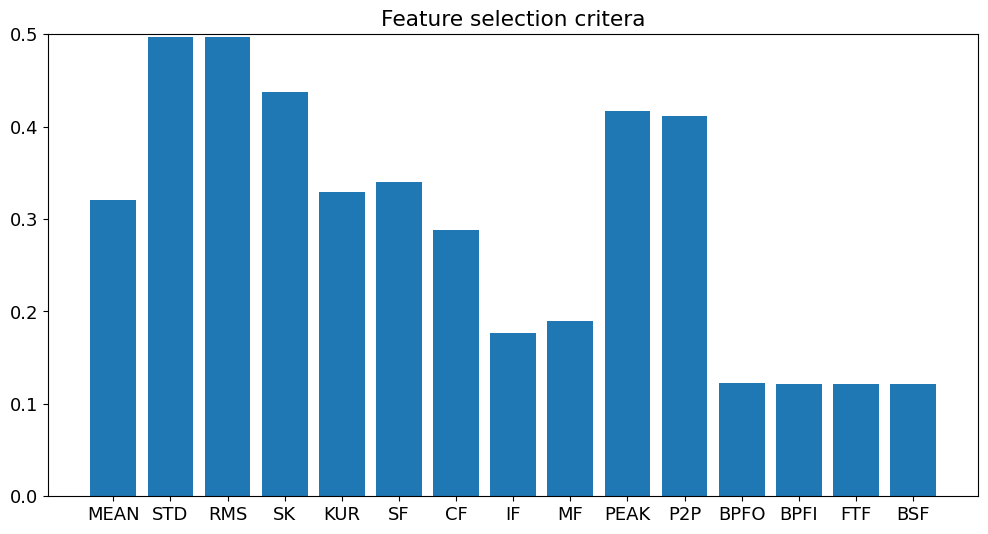

In [3]:
# 2. Feature selection for cabstone_prognosis
cycle = np.arange(0,N_file); w = np.mat([0.33, 0.33, 0.33])

# Normalizing
m = np.mean(features, axis=0); s = np.std(features, ddof=1, axis=0)
features = (features - m) / s

# Smoothing
from Functions.Smooth import smooth
features_smth = np.zeros_like(features)
for ix in range(np.shape(features)[1]):
    features_smth[:,ix] = smooth(features[:,ix], 50)

# Monotonicity
mon = np.abs(np.sum(np.diff(features_smth, axis=0)>0, axis=0)-np.sum(np.diff(features_smth, axis=0)<0, axis=0))/(N_file-1)

# Trendability
tre = np.abs(spearmanr(cycle, features_smth))[0,1:,0]

# Robustness
rob = np.zeros(15)
for ix in range(np.shape(features)[1]):
    rob[ix] = np.mean(np.exp(-np.abs(features[:,ix]-features_smth[:,ix]/features[:,ix])))
cri = np.ravel(np.c_[mon, tre, rob] * w.T)
ix = np.argsort(cri)[::-1]
cri_sort = cri[ix]

# Feature selection criteria <Figure 15(a)>
plt.figure(1, figsize=(12, 6)); plt.ylim(0,0.5)
plt.bar(range(0, 15), cri); plt.title('Feature selection critera')
plt.xticks(range(0, 15), feature_name)

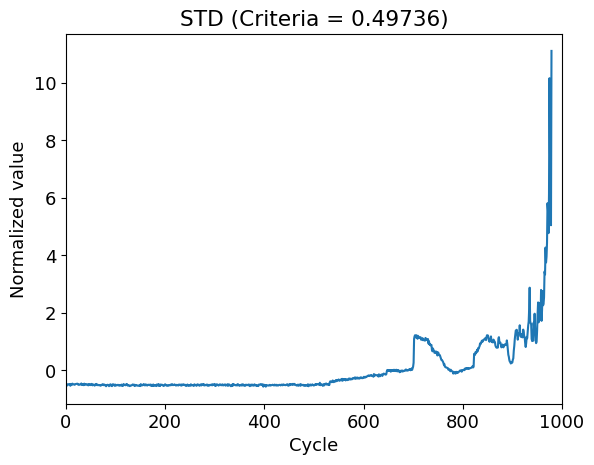

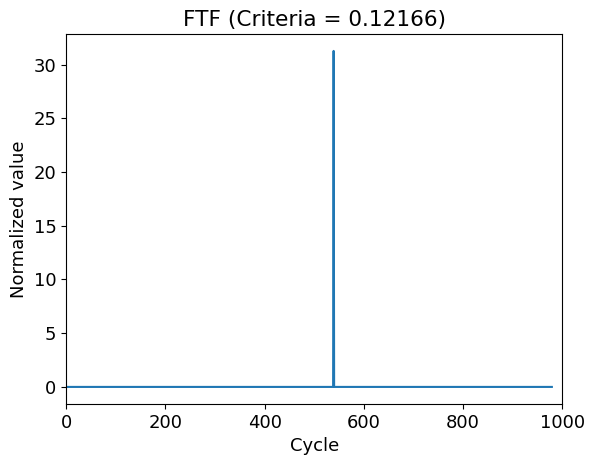

In [4]:
## 3. Prognostics Visualization using STD and IF
# High criteria <Figure 15(b)>
plt.figure(2); plt.plot(cycle, features[:,ix[0]])
plt.xlabel('Cycle'); plt.ylabel('Normalized value'); plt.xlim(0,1000)
plt.title(f'{feature_name[ix[0]]} (Criteria = {cri_sort[0]:.5f})')

# Low criteria <Figure 15(c)>
plt.figure(3); plt.plot(cycle, features[:,ix[-1]])
plt.xlabel('Cycle'); plt.ylabel('Normalized value'); plt.xlim(0,1000)
plt.title(f'{feature_name[ix[-1]]} (Criteria = {cri_sort[-1]:.5f})')
plt.show()